# Data Preprocessing

This notebook contains data preprocessing steps for all columns of the imported data alongside exploratory data analysis. It focuses on the columns **postcode** and **original_product_names**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# helpful character encoding module
import chardet

# regex package
import re

# for reversing character encoding issues 
import ftfy

# 'fuzz' to compare TWO strings, 'process' to compare a string to MULTIPLE other strings
from fuzzywuzzy import fuzz, process

In [2]:
# add src to module search path 

import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

if os.name == "nt":
    path_separator = "\\"
else:
    path_separator = "/"
    
module_path = f"{parent_dir}{path_separator}src"
sys.path.append(module_path)

# import helper functions
from utils import *

In [3]:
# display setting for rows
pd.set_option('display.max_rows', 100) 

## 1. Load raw data

In [4]:
file_path = '../data/raw/interview_signup.csv'

In [5]:
# check first couple thousand bytes to guess character encoding of csv
with open(file_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(20000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [6]:
# load csv with raw data
encoding = 'utf-8'
sep = ',' 
type_dict = {'original_product_name': str,
             'postcode': str,
             'bundesland': str,
             'total_bonus': 'float64',
             'order_date': str}

df_raw = pd.read_csv(file_path, 
                     encoding=encoding, 
                     sep=sep,
                     header=0,
                     dtype=type_dict
)

# make a copy to leave variable df_raw untouched
df = df_raw.copy()  
df.tail(5)

,original_product_name,postcode,bundesland,total_bonus,order_date
318340,E.ON STROM 24,49610,Niedersachsen,147.0,2018-12-31
318341,E.ON STROM,4916.0,NaN,142.0,2018-12-31
318342,E.ON STROM,77972.0,Baden-Württemberg,48.0,2018-12-31
318343,E.ON STROM ÖKO 24,91466,Bayern,238.0,2018-12-31
318344,E.ON STROM PUR,88145,Bayern,125.0,2018-12-31


## 2. Tranformations

### 2.1 General

In [7]:
# data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_product_name  318345 non-null  object 
 1   postcode               318345 non-null  object 
 2   bundesland             288813 non-null  object 
 3   total_bonus            318345 non-null  float64
 4   order_date             318345 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.1+ MB


Check if there are any duplicate rows in the dataset.

In [8]:
# check number of duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())


Number of duplicate rows:  170


If a lot of column entries will be modified in later transformation steps (e.g., filling missing values, string handling, ...), dropping duplicates should be done after these steps (again).

In [9]:
# before dropping, check duplicates where bundesland is empty
# df.loc[df.duplicated(keep=False) & df['bundesland'].isna()] 

In [10]:
df = df.drop_duplicates() 

Before cleansing of the columns, get an idea about percentage of missing records per columns

In [11]:
# missing values 
print('\nMissing values (%):')
print(np.round(df.isna().sum() / df.shape[0] * 100, 2))



Missing values (%):
original_product_name    0.00
postcode                 0.00
bundesland               9.28
total_bonus              0.00
order_date               0.00
dtype: float64


### 2.2 postcode

No missing values for postcode in the dataset. Because we specified dtype 'str' in read_csv(), we do not get mixed datatypes here:

In [12]:
# check for mixed datatypes 
df.postcode.apply(type).value_counts()

postcode
<class 'str'>    318175
Name: count, dtype: int64

To check the validity of postcode entries, use a regex to check against the records with custom function validate_postcode() from the utils module

In [13]:
# simplified regex for German postal codes
regex = r"^[0-9]{5}$"

# get logical index of valid postcodes (full matches)
idx_valid_postcode = df.postcode.apply(validate_string, pat=regex, fullmatch=True)

# display some invalid postcodes
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
df.loc[~idx_valid_postcode, 'postcode'].sample(10)

Number of remaining invalid postcodes:  91310


252464    27299.0
298523    46535.0
7135      97840.0
43468        1665
202902       4509
255820     6542.0
233693    32429.0
32824     73035.0
137776    54295.0
116921    64283.0
Name: postcode, dtype: object

We can observe at least 2 causes for invalid postcodes: 
1. trailing decimals
2. only 4 digits

Addressing 1., we need to ensure that the decimal pattern ".0" is removed from records. We use custom utils functions:

In [14]:
df['postcode'] = df['postcode'].apply(remove_trailing_decimal_pattern)
# alt.: df['postcode'] = df['postcode'].apply(lambda x: x.split(".0")[0])

# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_string, pat=regex, fullmatch=True)
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of invalid postcodes: \n", df.loc[~idx_valid_postcode, 'postcode'].sample(10))

Number of remaining invalid postcodes:  16610

Sample of invalid postcodes: 
 161615    6917
117005    1904
16214     8321
288875    9661
173840    1454
314075    6749
101575    1156
155665    6484
44294     9116
97291     6528
Name: postcode, dtype: object


We improved from 91,310 invalid records to 16,610 in this step. That's an improvement of roughly 80%. At this point, all postcodes with more than 5 digits should be dropped. Check the distribution of digits of the remaining 16,610 invalid postcodes:

In [15]:
# number of digits of remaining invalid postcodes
df.loc[~idx_valid_postcode, 'postcode'].apply(len).value_counts()

postcode
4     16609
10        1
Name: count, dtype: int64

In [16]:
# identify rows with more than 5 characters
idx_greater_5_chars = df['postcode'].apply(lambda x: True if len(x) > 5 else False)
print("postcodes with more than 5 digits: \n", df.loc[idx_greater_5_chars, :])

postcodes with more than 5 digits: 
        original_product_name    postcode bundesland  total_bonus  order_date
266922            E.ON STROM  92696JAVAS        NaN         97.0  2018-11-03


Looking at this record, we could use a partial regex matching. To validate the extraction from such a partial match, we could further check, if  we find other records with the same postcode. If the states match, we can be quite confident to keep the partial matches. Otherwise, dropping is the better option. 

In [19]:
# partial matching for 5 consecutive digits
set_partial_matches = set(df.loc[idx_greater_5_chars, 'postcode'].apply(extract_partial_match, pat=r"[0-9]{5}").unique())
print(set_partial_matches)

{'92696'}


In [25]:
# find records of other matching postcode records to compare bundesland
df.loc[df['postcode'].isin(set_partial_matches)]

,original_product_name,postcode,bundesland,total_bonus,order_date
13583,E.ON STROM 24,92696,Bayern,129.0,2018-01-16
56134,E.ON STROM,92696,Bayern,184.0,2018-03-06
56439,E.ON STROM 24,92696,Bayern,140.0,2018-03-06
57739,E.ON STROM,92696,Bayern,77.0,2018-03-08
73239,E.ON STROM 24,92696,Bayern,221.0,2018-03-26
124958,E.ON STROM,92696,Bayern,152.0,2018-05-24
154379,E.ON STROM ÖKO 24,92696,Bayern,143.0,2018-06-27
166329,E.ON STROM,92696,NaN,264.0,2018-07-10
173790,E.ON STROM,92696,Bayern,153.0,2018-07-19
205955,E.ON STROM 24,92696,Bayern,116.0,2018-08-25


Unfortunately, there is no state in the row with index 266922 (see 4 cells above). If the state was "Bayern" (see cell above), we could have been quite confident in recovering the postcode by taking the first 5 characters of the string "92696JAVAS". Since it is only 1 record, drop this row. Future development could try to make this analysis with partial matchings and cross-checking with entries of column bundesland more reproducible and scalable

In [26]:
# drop rows
df = df.drop(df.loc[idx_greater_5_chars].index)

The remaing 4 digits postcodes very likely come from conversion to int, where the leading 0 was removed. However, other unkown inconsistencies can apply. We need to be rather sure *not* to add "0" digits to otherwise corrupted postcodes in the dataset.

The **naiv approach** would be to simply add a leading "0" to all remaining 4 digit records, since most likely it was removed during type conversion to int or float. If we had access to processing pipeline of the data source, this could be verified rather easily. Since we can't be 100% sure whether all of the remaining records are missing a leading 0 or are corrupted otherwise, we take a more **conservative approach**:

To further clean the invalid entries of this column, we can use the fact that only the federal states "Sachsen", "Brandenburg", "Sachsen-Anhalt" and "Thüringen" have a leading "0" in their postal code. For rows still having invalid postcodes **and** one of these states, we can add a "0" to the postcodes.

In [30]:
# states with leading 0 in der postcode
states_w_lead_0 = ["Sachsen", "Brandenburg", "Sachsen-Anhalt", "Thüringen"]

# logical index for all states with leading 0 as postcode
idx_state_w_lead_0 = df['bundesland'].isin(states_w_lead_0)

In [31]:
# check the unique states for the remaining invalid postcodes
df.loc[~idx_valid_postcode, 'bundesland'].value_counts(dropna=False)

bundesland
Sachsen           8637
NaN               3225
Sachsen-Anhalt    2137
Thüringen         1955
Brandenburg        655
Name: count, dtype: int64

For rows with non-empty 'bundesland', we can add a leading 0 and keep the data. For the records with no corresponding state, we need one final logical transformation step.

Next, let's pad all postcodes with "0" from the left until they reach 5 digits.

In [32]:
# pad all postcodes with "0" from the right until they have 5 digits
df.loc[idx_state_w_lead_0, 'postcode'] = df.loc[idx_state_w_lead_0, 'postcode'].str.rjust(5, fillchar='0')

In [35]:
# confirm successful transformation
df.loc[idx_state_w_lead_0 & ~idx_valid_postcode, ['postcode','bundesland']].sample(10)

,postcode,bundesland
30694,01159,Sachsen
74666,06712,Sachsen-Anhalt
230096,07407,Thüringen
265259,09241,Sachsen
82291,03116,Brandenburg
113145,06258,Sachsen-Anhalt
30202,04158,Sachsen
52186,08304,Sachsen
50368,01109,Sachsen
13206,03185,Brandenburg


In [36]:
# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_string, pat=regex, fullmatch=True)

# display invalid postcodes: 4 digits
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of remaining invalid postcodes: \n", df.loc[~idx_valid_postcode, ['postcode', 'bundesland']].sample(10))

Number of remaining invalid postcodes:  3225

Sample of remaining invalid postcodes: 
        postcode bundesland
247472     6528        NaN
24760      8280        NaN
190796     1920        NaN
195836     8548        NaN
74123      1920        NaN
85033      6463        NaN
92806      2997        NaN
28914      3046        NaN
275637     6120        NaN
96891      6110        NaN


Lastly, we deal with the remaining 3,225 records with invalid postcode where the 'bundesland' column is empty. Compared to the initial 91,310 invalid cases, we have recovered over 96% of the corrupted records already. 

Taking the **conservative approach** (because we seem to have enough data), we can still make use of the "almost" N:1 relationship between postcodes and states (i.e., one postcode can only have one state except from extreme rare cases). The idea is to infer the remaining unclear cases by assuming a leading 0 and see if this resulting postcode can be found elsewhere in the dataset with an assigned state in ["Sachsen", "Brandenburg", "Sachsen-Anhalt", "Thüringen"]. This is a rather complex logic and needs to be implemented with care to guarantee scalable data processing.

In [37]:
# init a dictionary for storage of data
dict_pc = {} 

# logical index for all rows of the dataframe without a state entry
idx_state_not_empty = ~df['bundesland'].isna()

# loop through remaining postcodes
for pc in list(df.loc[~idx_valid_postcode, 'postcode'].unique()):
    
    # create a dummy postcode with leading "0"
    dummy_pc = "0" + pc
    
    # logical index for positions of current postcode iterator
    idx_dummy_match = df['postcode']==dummy_pc
    
    # check if there are other records with same postcode and filled out state
    if any(idx_dummy_match):
        if all(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'].isna()):
            pass
        elif len(set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'])) > 1:  # if one postcode has several states
            pass
        elif not set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland']).issubset(states_w_lead_0):  # if the postcodes correspond to any of the 4 states above
            pass
        else:            
            dict_pc[pc] = set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'])
    
print(dict_pc)

{'9366': {'Sachsen'}, '4626': {'Thüringen'}, '1594': {'Sachsen'}, '4769': {'Sachsen'}, '1990': {'Brandenburg'}, '1737': {'Sachsen'}, '9573': {'Sachsen'}, '6217': {'Sachsen-Anhalt'}, '1968': {'Brandenburg'}, '8107': {'Sachsen'}, '4924': {'Brandenburg'}, '3096': {'Brandenburg'}, '7613': {'Thüringen'}, '7426': {'Thüringen'}, '8223': {'Sachsen'}, '2742': {'Sachsen'}, '7570': {'Thüringen'}, '8468': {'Sachsen'}, '6632': {'Sachsen-Anhalt'}, '7422': {'Thüringen'}, '2991': {'Sachsen'}, '6618': {'Sachsen-Anhalt'}, '8606': {'Sachsen'}, '1904': {'Sachsen'}, '2894': {'Sachsen'}, '7806': {'Thüringen'}, '1723': {'Sachsen'}, '4828': {'Sachsen'}, '3149': {'Brandenburg'}, '6642': {'Sachsen-Anhalt'}, '1920': {'Sachsen'}, '8626': {'Sachsen'}, '2906': {'Sachsen'}, '1855': {'Sachsen'}, '2747': {'Sachsen'}, '4916': {'Brandenburg'}, '4827': {'Sachsen'}, '8541': {'Sachsen'}, '1609': {'Sachsen'}, '6628': {'Sachsen-Anhalt'}, '6268': {'Sachsen-Anhalt'}, '8233': {'Sachsen'}, '6242': {'Sachsen-Anhalt'}, '8527': {'S

In [38]:
df.loc[df['postcode'].isin(dict_pc.keys()), 'postcode'] = df.loc[df['postcode'].isin(dict_pc.keys()), 'postcode'].str.rjust(5, fillchar='0')

In [39]:
# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_string, pat=regex, fullmatch=True)

# display invalid postcodes: 4 digits
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of remaining invalid postcodes: \n", df.loc[~idx_valid_postcode, ['postcode', 'bundesland']].sample(10))

Number of remaining invalid postcodes:  2351

Sample of remaining invalid postcodes: 
        postcode bundesland
243571     9638        NaN
93955      9669        NaN
22528      9465        NaN
38048      6366        NaN
168807     6886        NaN
113511     6917        NaN
159238     9380        NaN
132846     6118        NaN
228431     3058        NaN
166648     2959        NaN


We have 2,351 invalid postcodes left from originally 91,310 (97,5% recovery rate). If data would not be vastly available, we might add a leading 0 to the rest of the records. For now, let's avoid false-positive or false-negative classification as much as we can where overall information quality is not great. 

Therefore, we drop the rest of the rows. But before, let's check if the remaining invalid records can be systematically linked to anomalies in other columns (e.g. all happened around the same time of the year):

In [40]:
# get sample of remaining invalid postcodes
df.loc[~idx_valid_postcode, :].sample(5)

,original_product_name,postcode,bundesland,total_bonus,order_date
168632,E.ON STROM,9376,NaN,86.0,2018-07-13
158741,E.ON STROM,6809,NaN,86.0,2018-07-02
189501,E.ON STROM,9350,NaN,168.0,2018-08-06
235830,E.ON STROM 24,8209,NaN,189.0,2018-09-29
206883,E.ON STROM,7980,NaN,243.0,2018-08-26


In [41]:
# Can the missing postcodes be systematically attributed to a date?

# number of invalid postcodes by order_date
df.loc[~idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().describe()  # .sort_values(ascending=False)
# df.loc[~idx_valid_postcode, 'order_date'].value_counts().sort_values(ascending=False)
# df.loc[~idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().plot()

# number of valid postcodes with empty state by order_date
df.loc[~idx_state_not_empty & idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().describe()  # sort_values(ascending=False)
# df.loc[~idx_state_not_empty & idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().plot()


count    365.000000
mean      74.435616
std        8.519167
min       48.000000
25%       68.000000
50%       75.000000
75%       80.000000
max       99.000000
Name: postcode, dtype: float64

In [42]:
# drop rows with invalid postcodes
df.drop(df.loc[~idx_valid_postcode].index, inplace=True)

Finally, we check again for duplicated records, since the cleaning of postcodes may have created new duplicates that we missed before.

In [43]:
# check number of duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())

Number of duplicate rows:  62


In [44]:
# drop duplicates
df = df.drop_duplicates()

In [45]:
df.shape[0]

315761

### 2.3 original_product_name

Understand unique values: 

In [50]:
print('Number of unique values: ', df['original_product_name'].nunique())

df['original_product_name'].unique()

Number of unique values:  9


array(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24',
       'E.ON STROM 24', 'E.ON STROM PUR', 'E.ON STROM 24 24 24',
       'E.ON STROM 24 24', 'E.ON STROM ÖO',
       'E.ON STROM 24 24 24 24 24 24 24'], dtype=object)

In [51]:
# look at distribution of unique values
df['original_product_name'].value_counts()

original_product_name
E.ON STROM                         162947
E.ON STROM 24                       68852
E.ON STROM ÖKO                      55044
E.ON STROM ÖKO 24                   25265
E.ON STROM PUR                       3634
E.ON STROM 24 24                       14
E.ON STROM 24 24 24                     2
E.ON STROM 24 24 24 24 24 24 24         2
E.ON STROM ÖO                           1
Name: count, dtype: int64

Type conversion to category to save memory

In [52]:
df['original_product_name'] = df['original_product_name'].astype("category")

Address misspellings with the following steps
1. some ambiguous data (i.e., E.ON STROM Ã–KO) seem to come from wrong encoding. We can use the ftfy library to retrieve desired characters
2. for the remaining inconsistencies, we apply a mapping that uses fuzzy matching to correct typos in the product name. We use fuzzy instead to more fancy techniques, because we care more about character-level similarities than about contextual similarity

In [49]:
# 1. Fix misspellings caused by encoding

# convert wrongly decoded characters to utf-8 
df['original_product_name'] = df['original_product_name'].apply(lambda x: ftfy.fix_text(x))

# check which products were converted 
converted_product_names = set(df_raw['original_product_name'].unique()).difference(set(df['original_product_name'].unique()))
print(f"These product names were successfully integrated into the existing products names: {converted_product_names}.\n")

# check if ftfy introduced new products 
new_product_names = set(df['original_product_name'].unique()).difference(set(df_raw['original_product_name'].unique()))
if len(new_product_names)==0:
    new_product_names=None
print(f"Potentially wrongly created new 'false positive' products names: {new_product_names}.")

These product names were successfully integrated into the existing products names: {'E.ON STROM Ã–KO'}.

Potentially wrongly created new 'false positive' products names: None.


We can see that the 206 instances of E.ON STROM Ã–KO now moved to E.ON STROM ÖKO (from 55,187 to 55,393)

In [53]:
df['original_product_name'].value_counts()

original_product_name
E.ON STROM                         162947
E.ON STROM 24                       68852
E.ON STROM ÖKO                      55044
E.ON STROM ÖKO 24                   25265
E.ON STROM PUR                       3634
E.ON STROM 24 24                       14
E.ON STROM 24 24 24                     2
E.ON STROM 24 24 24 24 24 24 24         2
E.ON STROM ÖO                           1
Name: count, dtype: int64

To make this cleaning process more scalable and less manual, we use fuzzywuzzy:
1. identify the real products manually (this is saver in business context). Could be automated with number of occurance of each product name.
2. apply similarity measure 'token_sort_ratio' of fuzzywuzzy to quantify how close the odd product names are to the set of real ones -> Take the closest match with the real product name. Alternatively, define a similarity threshold that cannot be undercut. Otherwise, the character gets not matching and will be dropped later.
3. map this to the original column

In [54]:
# define actual product names
real_product_names = set(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24', 'E.ON STROM PUR', 'E.ON STROM 24'])

# get set of all unique entries (with misspellings)
all_product_names = set(df['original_product_name'].unique())

# identify all non-official product names
odd_product_names = all_product_names - real_product_names

In [55]:
# fuzzy matching
dict_fuzzy_matching = {}
for prod in odd_product_names:
    # extract only closest match with real product name
    dict_fuzzy_matching[prod] = process.extract(prod, real_product_names, limit=1, scorer=fuzz.token_sort_ratio)[0][0]
print(dict_fuzzy_matching)

{'E.ON STROM 24 24 24 24 24 24 24': 'E.ON STROM 24', 'E.ON STROM ÖO': 'E.ON STROM ÖKO', 'E.ON STROM 24 24 24': 'E.ON STROM 24', 'E.ON STROM 24 24': 'E.ON STROM 24'}


In [56]:
# create dict to map the actual product names to themselves
dict_real_names = {}
for prod in real_product_names:
    dict_real_names[prod] = prod

# join the two dictionaries
product_mapping = {**dict_real_names, **dict_fuzzy_matching}

# apply to column
df['original_product_name'] = df['original_product_name'].map(product_mapping)
    

In [57]:
# check transformation
df['original_product_name'].value_counts()

original_product_name
E.ON STROM           162947
E.ON STROM 24         68870
E.ON STROM ÖKO        55045
E.ON STROM ÖKO 24     25265
E.ON STROM PUR         3634
Name: count, dtype: int64

In [ ]:
"""
# Function to find the best match for each variation
def find_best_match(variation, standardized_names):
    best_match = None
    max_similarity = -1
    
    for name in standardized_names:
        similarity = fuzz.ratio(variation, name)
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = name
    
    return best_match

# List of standardized names
standardized_names = ['E.ON STROM', 'E.ON STROM 24', 'E.ON STROM ÖKO', 'E.ON STROM PUR']

# Apply Levenshtein distance to find the best match for each variation
df['original_product_name_fuzzy'] = df['original_product_name'].apply(lambda x: find_best_match(x, standardized_names))

# Print the cleaned data
print(df[['original_product_name', 'original_product_name_fuzzy']])
"""

### 2.4 bundesland

In [58]:
# convert int to category for memory
df['original_product_name'] = df['original_product_name'].astype("category")

In [59]:
# missing values
df['bundesland'].isna().sum()

27162

In [60]:
len(df['bundesland'].unique())

17

In [61]:
df['bundesland'].value_counts(dropna=False)

bundesland
Nordrhein-Westfalen       68454
Bayern                    50718
Baden-Württemberg         35430
Niedersachsen             34850
NaN                       27162
Hessen                    19886
Rheinland-Pfalz           16342
Schleswig-Holstein        12956
Brandenburg                8791
Sachsen                    8637
Berlin                     8255
Thüringen                  5972
Mecklenburg-Vorpommern     5478
Sachsen-Anhalt             4453
Hamburg                    3951
Saarland                   2986
Bremen                     1440
Name: count, dtype: int64

Check if there exists a N:1 relationship between postcode and bundesland:

In [62]:
# check if the N:1 relationship between postcode and state is obeyed
# BEWARE: there are very few special cases where one postcode can belong to more than one state
no_violations = sum(df.groupby(by=['postcode'])['bundesland'].nunique()>1)
print('Number of N:1 relationship violations between postcode and bundesland: ', no_violations)

Number of N:1 relationship violations between postcode and bundesland:  9


In [63]:
# retrieve the postcodes
violations = df.groupby(by=['postcode'])['bundesland'].nunique()>1
pc_violations = list(violations.index[violations])
print(pc_violations)

['14715', '17337', '19357', '21039', '22113', '22145', '59969', '65391', '69434']


In [64]:
# create dataframe with the counts of each postcode, bundesland combination
grouping = df.loc[df['postcode'].isin(pc_violations),:].groupby(by=['postcode','bundesland'])['order_date'].count()  
df_grouping = grouping.to_frame()

# Convert tuple index back to two separate columns
df_grouping = df_grouping.reset_index()
df_grouping.columns = ['postcode', 'bundesland', 'count']

print(df_grouping)

   postcode              bundesland  count
0     14715             Brandenburg     70
1     14715          Sachsen-Anhalt      6
2     17337             Brandenburg     11
3     17337  Mecklenburg-Vorpommern      8
4     19357             Brandenburg      7
5     19357  Mecklenburg-Vorpommern      2
6     21039                 Hamburg     20
7     21039      Schleswig-Holstein     59
8     22113                 Hamburg      3
9     22113      Schleswig-Holstein     24
10    22145                 Hamburg     33
11    22145      Schleswig-Holstein     27
12    59969                  Hessen     16
13    59969     Nordrhein-Westfalen     24
14    65391                  Hessen     23
15    65391         Rheinland-Pfalz      1
16    69434       Baden-Württemberg      1
17    69434                  Hessen      9


Upon manual checks, all the above cases are valid. The data is not corrupted. 
To fill the missing bundesland values, we use the mapping between postcode and bundesland. For each missing bundesland entries, we use their postcodes to infer the state from other existing records where the state was filled. 
For any given cases, we fill NaNs with that most occuring state (and set the occurance of NaN entries to 0 by design)

In [65]:
# create a dictionary with all unique postcode. 
# Count the number of occurance for all unique states assigned to this postcode and store it in a list of tuples 

# init final dict
dict_pc = {}

# loop through all unique postcodes
for pc in list(df['postcode'].unique()):
    
    # logical index for current postcode
    idx_pc = df['postcode']==pc
    
    # list of unique states for current postcode (with NaN)
    list_state = list(df.loc[idx_pc, 'bundesland'].unique())
    
    # init list 
    dict_pc[pc] = []
    
    # loop through all unique states of current postcode
    for state in list_state:
        
        # count occurences of states for current postcode 
        dict_pc[pc].append((state, sum(idx_pc & (df['bundesland']==state))))  # NaN will be counted as 0 occurance
    

In [66]:
postcode_state_mapping = {}

for key, tuples in dict_pc.items():
    max_occur_state_tuple = max(tuples, key=lambda x: x[1])
    postcode_state_mapping[key] = max_occur_state_tuple[0]  # get state with most occurances

print(postcode_state_mapping)

{'53229': 'Nordrhein-Westfalen', '74235': 'Baden-Württemberg', '45257': 'Nordrhein-Westfalen', '64395': 'Hessen', '36039': 'Hessen', '12357': 'Berlin', '13088': 'Berlin', '73207': 'Baden-Württemberg', '23795': 'Schleswig-Holstein', '58638': 'Nordrhein-Westfalen', '37079': 'Niedersachsen', '88605': 'Baden-Württemberg', '26810': 'Niedersachsen', '30890': 'Niedersachsen', '39326': 'Sachsen-Anhalt', '85646': 'Bayern', '58454': 'Nordrhein-Westfalen', '31749': 'Niedersachsen', '30880': 'Niedersachsen', '31162': 'Niedersachsen', '88512': 'Baden-Württemberg', '52152': 'Nordrhein-Westfalen', '70567': 'Baden-Württemberg', '57520': 'Rheinland-Pfalz', '04319': 'Sachsen', '46045': 'Nordrhein-Westfalen', '90762': 'Bayern', '45964': 'Nordrhein-Westfalen', '77948': 'Baden-Württemberg', '28199': 'Bremen', '30171': 'Niedersachsen', '08315': 'Sachsen', '21266': 'Niedersachsen', '10627': 'Berlin', '16341': 'Brandenburg', '28201': 'Bremen', '69198': 'Baden-Württemberg', '60596': nan, '99988': nan, '64572':

In [67]:
for key, val in postcode_state_mapping.items():
    
    # logical index on current postcode
    idx_pc = df['postcode']==key
    
    # logical index on missing values
    idx_state_empty = df['bundesland'].isna()
        
    # fillna
    df.loc[idx_pc & idx_state_empty, 'bundesland'] = val

In [68]:
df['bundesland'].isna().sum()

20028

This method reduced the number of missing values from 27,162 to 20,028 (26% recovery). For the remaining empty entries, we could either use a external dataset (or api) with postcode - state mappings or try geocoding.

In [86]:
print('Number of duplicate rows: ', df.duplicated().sum())
df = df.drop_duplicates()

Number of duplicate rows:  5


### 2.5 order_date

In [69]:
# what different data types are in the column order_date?
df.order_date.apply(type).value_counts()

order_date
<class 'str'>    315761
Name: count, dtype: int64

In [70]:
# convert order_date to date
df['order_date'] = pd.to_datetime(df['order_date'], format="%Y-%m-%d")
df['order_date'] = df['order_date'].dt.date

In [71]:
#pd.to_datetime(df['order_date'], errors='coerce', format="%Y-%m-%d").isnull().sum()

In [72]:
# check for missing dates
day_diffs = [el.days for el in np.diff(df['order_date'].unique())]
print("Number of unique dates: ", len(day_diffs))
print("Number of consecutive days: ", day_diffs.count(1))

Number of unique dates:  364
Number of consecutive days:  364


In [73]:
# number of rows per date
df['order_date'].value_counts().describe()
# df['order_date'].value_counts().plot.bar()

count    365.00000
mean     865.09863
std       29.48917
min      790.00000
25%      845.00000
50%      864.00000
75%      886.00000
max      954.00000
Name: count, dtype: float64

### 2.6 total_bonus

In [74]:
# check if we really need float64 to store the total_bonus or if we can save some memory by using int.

# if total_bonus converted to int are identical with float, use int
if sum(df['total_bonus'] != df['total_bonus'].astype(int)) == 0:
    df['total_bonus'] = df['total_bonus'].astype(int)

How are the data distributed?

In [75]:
df['total_bonus'].describe()

count    315761.000000
mean        150.650106
std          53.713878
min           0.000000
25%         113.000000
50%         149.000000
75%         182.000000
max         570.000000
Name: total_bonus, dtype: float64

In [76]:
df.loc[(df['total_bonus']>0) & (df['total_bonus']<20)]

,original_product_name,postcode,bundesland,total_bonus,order_date
215,E.ON STROM ÖKO,41238,Nordrhein-Westfalen,17,2018-01-01
641,E.ON STROM,21493,Schleswig-Holstein,18,2018-01-01
890,E.ON STROM,22043,Hamburg,9,2018-01-02
1203,E.ON STROM 24,07958,Thüringen,12,2018-01-02
3033,E.ON STROM 24,54329,Rheinland-Pfalz,8,2018-01-04
...,...,...,...,...,...
316702,E.ON STROM,41812,Nordrhein-Westfalen,13,2018-12-30
316738,E.ON STROM 24,07907,Thüringen,11,2018-12-30
316914,E.ON STROM,76891,Rheinland-Pfalz,18,2018-12-30
317136,E.ON STROM,18374,Mecklenburg-Vorpommern,17,2018-12-30


In [77]:
df.loc[df['total_bonus']>=400]

,original_product_name,postcode,bundesland,total_bonus,order_date
572,E.ON STROM,91257,Bayern,436,2018-01-01
4254,E.ON STROM ÖKO,53343,Nordrhein-Westfalen,461,2018-01-05
4640,E.ON STROM ÖKO 24,24629,Schleswig-Holstein,428,2018-01-06
6259,E.ON STROM ÖKO,14050,Berlin,428,2018-01-08
7362,E.ON STROM ÖKO 24,35647,Hessen,430,2018-01-09
...,...,...,...,...,...
308905,E.ON STROM,12353,Berlin,418,2018-12-21
310518,E.ON STROM,31246,Niedersachsen,414,2018-12-23
313070,E.ON STROM ÖKO 24,24939,Schleswig-Holstein,420,2018-12-26
315651,E.ON STROM,90491,Bayern,421,2018-12-28


<Axes: >

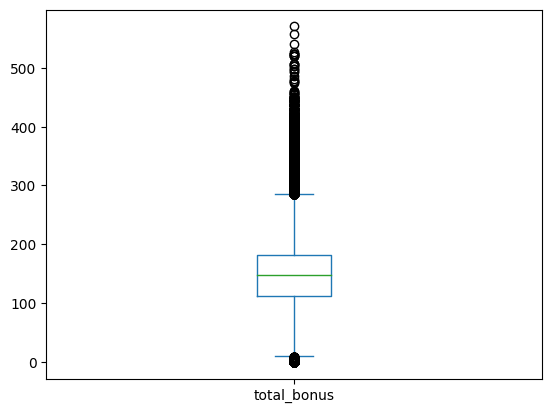

In [78]:
# boxplot 
df['total_bonus'].plot(kind='box')

<Axes: xlabel='total_bonus', ylabel='Count'>

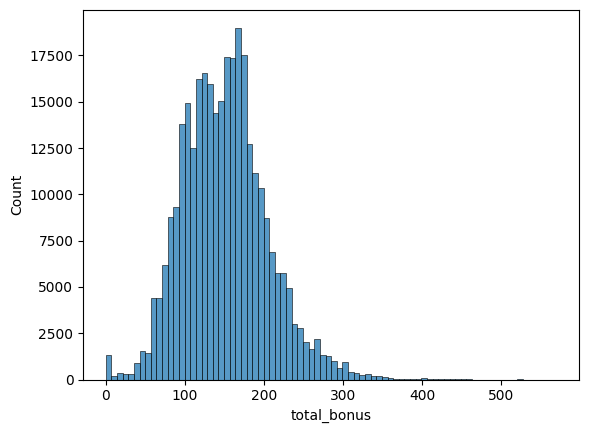

In [79]:
# empirical distribution
sns.histplot(df['total_bonus'], bins=80)

In [80]:
# test for normality? scipy -> statisitcal tests, qqplot, ...

Are values of ```total_bonus=0``` correct? Check if there are anomalies in other features that may cause total_bonus to be 0:

In [81]:
# create df where all total_bonus are 0
df_no_bonus = df.loc[df['total_bonus']==0, :]

# fill missing states with 'leer' so that it appears in countplots
df['bundesland'] = df['bundesland'].fillna('leer')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Rheinland-Pfalz'),
  Text(1, 0, 'Niedersachsen'),
  Text(2, 0, 'Bayern'),
  Text(3, 0, 'Nordrhein-Westfalen'),
  Text(4, 0, 'Schleswig-Holstein'),
  Text(5, 0, 'Brandenburg'),
  Text(6, 0, 'Hessen'),
  Text(7, 0, 'Baden-Württemberg'),
  Text(8, 0, 'Mecklenburg-Vorpommern'),
  Text(9, 0, 'Berlin'),
  Text(10, 0, 'Thüringen'),
  Text(11, 0, 'Hamburg'),
  Text(12, 0, 'Sachsen-Anhalt'),
  Text(13, 0, 'Saarland'),
  Text(14, 0, 'Sachsen')])

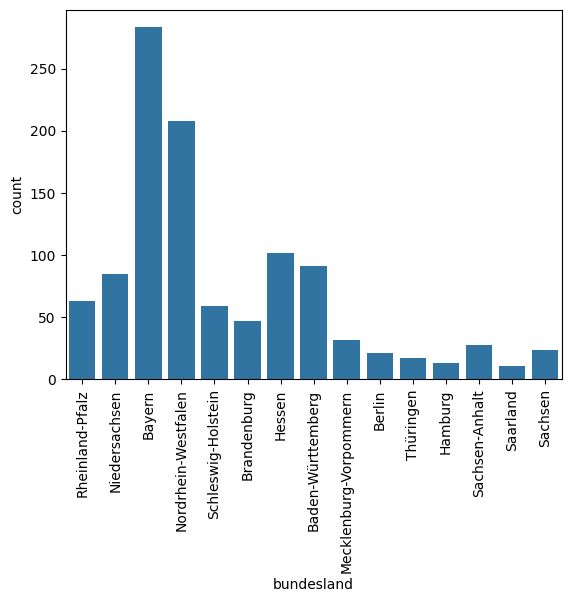

In [82]:
sns.countplot(data=df_no_bonus, x='bundesland')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'E.ON STROM'),
  Text(1, 0, 'E.ON STROM 24'),
  Text(2, 0, 'E.ON STROM PUR'),
  Text(3, 0, 'E.ON STROM ÖKO'),
  Text(4, 0, 'E.ON STROM ÖKO 24')])

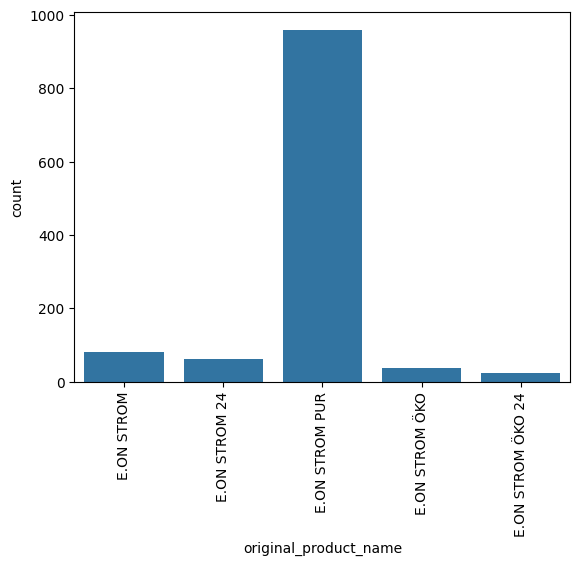

In [83]:
sns.countplot(data=df_no_bonus, x='original_product_name')
plt.xticks(rotation=90)

In [84]:
# test cou

Most of the cases where ```total_bonus = 0``` coincides with customers choosing the E.ON STROM PUR product.

Can we observe temporal patterns, where total_bonus is zero?

In [88]:
# day of year
df['doy'] = pd.to_datetime(df['order_date']).dt.day_of_year

df_group_doy = df.groupby('doy')['total_bonus'].mean().to_frame()
df_group_doy = df_group_doy.reset_index()

<Axes: xlabel='doy'>

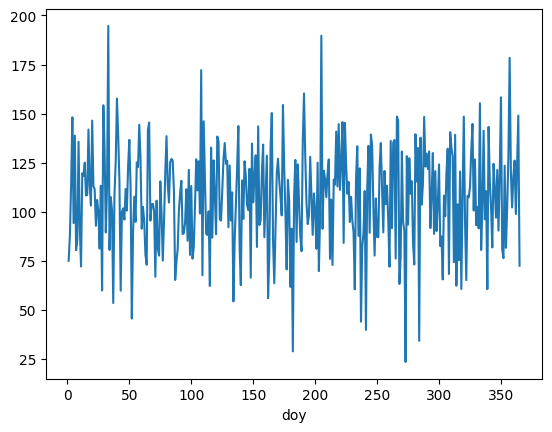

In [89]:
df.loc[df['original_product_name']=='E.ON STROM PUR',:].groupby(by = ['doy'])['total_bonus'].mean().plot()

<Axes: xlabel='doy', ylabel='total_bonus'>

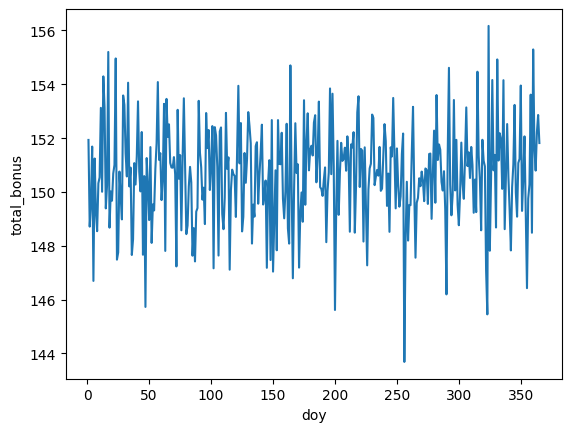

In [90]:
sns.lineplot(data = df_group_doy, x='doy', y='total_bonus')

Are there aggregated monthly or weekly anomalies?

<Axes: xlabel='week'>

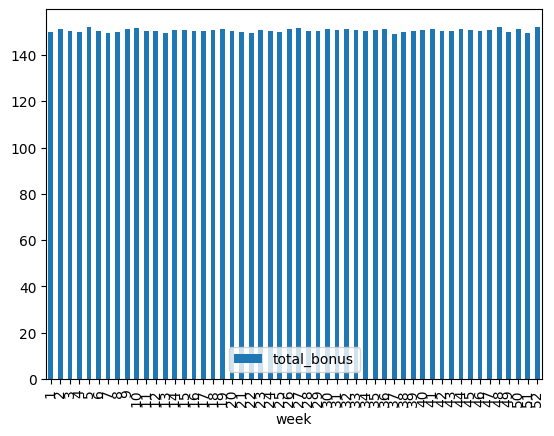

In [91]:
df['week'] = pd.to_datetime(df['order_date']).dt.isocalendar().week
df[['week','total_bonus']].groupby(by=['week']).mean().plot.bar()

In [92]:
df['month-year'] = pd.to_datetime(df['order_date']).dt.strftime('%B-%Y')
print(df[['month-year','total_bonus']].groupby(by=['month-year']).mean())

# df[['month-year','total_bonus']].groupby(by=['month-year']).mean().plot.bar()

                total_bonus
month-year                 
April-2018       150.583476
August-2018      150.909874
December-2018    150.899690
February-2018    150.471105
January-2018     150.691123
July-2018        150.873130
June-2018        150.570955
March-2018       150.463097
May-2018         150.508024
November-2018    151.010447
October-2018     150.638833
September-2018   150.150924


# 3. Store processed data

In [94]:
df.to_csv('../data/processed/interview_signup_processed.csv')